# Overview

In this notebook we will go over a basic example of how to use Squidward for gaussian process (GP) classification. This is not a tutorial on how GP classification works or should be done; it is merely an example of how to use Squidward for a simple classification problem. Squidward implements GP classification using the one vs. all methodology commonly implemented for logistic regression multi-classification. It is recommended to review the squidward simple regression example before going through this classification example.

We'll begin by importing the packages needed to go through these examples!

In [1]:
# model with squidward
from squidward.kernels import distance, kernel_base
from squidward import gpc, gp_viz, validation

# generate example data
import numpy as np

# plot example data
import matplotlib.pyplot as plt
import seaborn as sns

plt.set_cmap('winter')

### 2D Classification Example

To demonstrate classification with squidward we will use a very simple two dimensional classification example. Here we generate a simple 2D train set, fit a GP to that data, and display the mean and variance of our predictions in an easy to interpret plot.

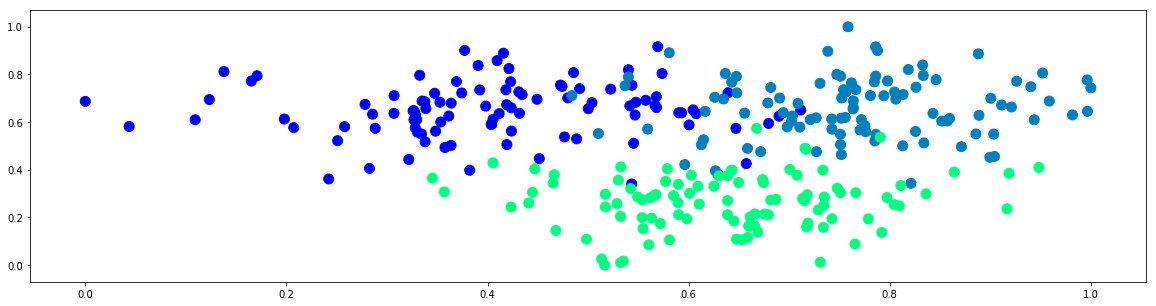

In [2]:
n = 100
cov = [[5,0],[0,5]]

x1 = np.random.multivariate_normal(mean=[2,10],cov=cov,size=n)
y1 = np.zeros(n)
x2 = np.random.multivariate_normal(mean=[8,10],cov=cov,size=n)
y2 = np.ones(n)
x3 = np.random.multivariate_normal(mean=[6,3],cov=cov,size=n)
y3 = np.ones(n)*2

x = np.concatenate([x1,x2,x3])
y = np.concatenate([y1,y2,y3]).reshape(-1,1)

X_std = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
x = X_std * (1.0 - 0.0) + 0.0

plt.figure(figsize=(20,5))
plt.scatter(x[:,0],x[:,1],c=y[:,0],s=100)
plt.show()

In the regression example we used the built in radial basis function kernel. We did this by passing the rbf distance measure to the base kernel class.  Here we will create a custom kernel theat will be the additive combination of a rbf kernel over each dimension in the train dataset. Squidward makes it very easy to make custom kernel as shown below.

In [3]:
# custom distance function
def d(alpha, beta):
    d1 = distance.RBF(0.2,35.0**2)
    d2 = distance.RBF(0.2,35.0**2)
    return d1(alpha[0],beta[0]) + d1(alpha[1],beta[1])

In [4]:
# the kernel base class takes the distance measure of choice
# as well as the method for evaluating the kernel (the default
# is k1 which is analogous to the scipy.distance.cdit fuction v1.2.0)
kernel = kernel_base.Kernel(d, 'k1')

In [5]:
# the model is instantiated with the kernel
# object as well as a likelihood variance (equivalent
# of a white noise kernel to model data noise)
# there is also a variety of choices for matrix
# inversion methods that trade of numeric stability and speed
model = gpc.GaussianProcess(kernel=kernel,var_l=1.0**2,inv_method='lu')

In [6]:
# generate data to plot posterior of GP
x_test = np.mgrid[0:1:0.05,0:1:0.05].reshape(2,-1).T

/anaconda3/envs/squidward_env/lib/python3.6/site-packages/squidward/utils.py:51: UserWarning: Cov has high condition. Inverting matrix may result in errors.
  warnings.warn('Cov has high condition. Inverting matrix may result in errors.')


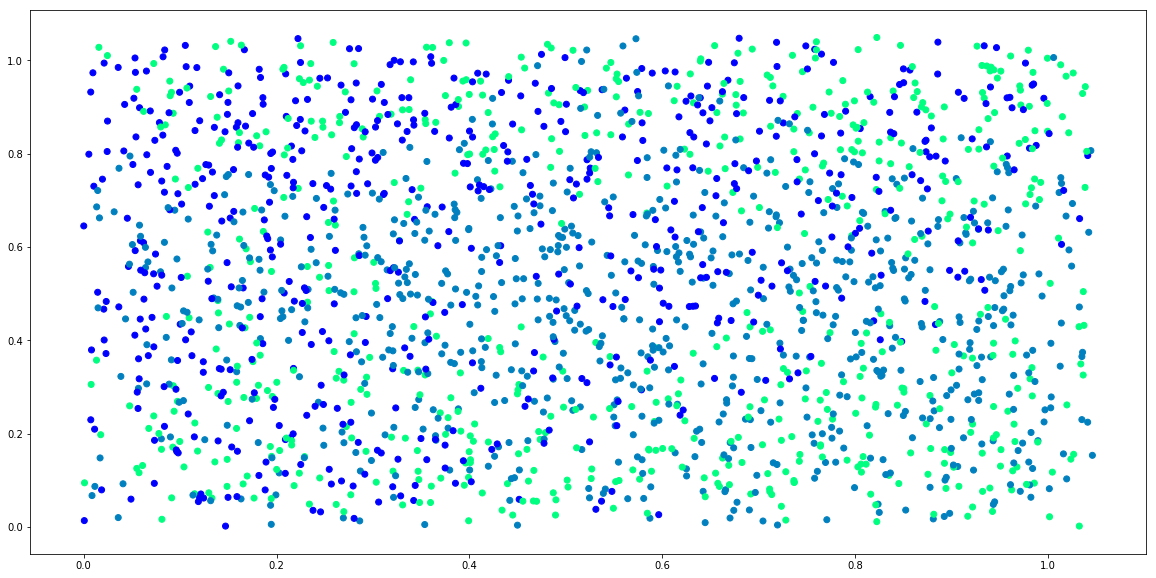

In [7]:
# plot samples from prior
plt.figure(figsize=(20,10))
for i in range(5):
    _x = x_test + 0.1*np.random.rand(x_test.shape[0], x_test.shape[1])
    sample = model.prior_sample(_x,3).argmax(axis=1)
    plt.scatter(_x[:,0], _x[:,1], c=sample)
plt.show()

In [8]:
# the model object is largely inspired by the
# scikitlearn interface
# simply call fit to "train" the model
model.fit(x,y)

In [9]:
# pull predictions from the posterior distribution
mean  = model.posterior_predict(x)
predictions = mean.argmax(axis=1)

In [10]:
# do basic validation

accuracy = validation.acc(predictions, y)
print("Train Accuracy: {}".format(accuracy))

Train Accuracy: 0.9166666666666666


In [11]:
# generate data to plot posterior of GP
x_test = np.mgrid[0:1:0.05,0:1:0.05].reshape(2,-1).T

# pull predictions from the posterior distribution
mean  = model.posterior_predict(x_test)
predictions = mean.argmax(axis=1)

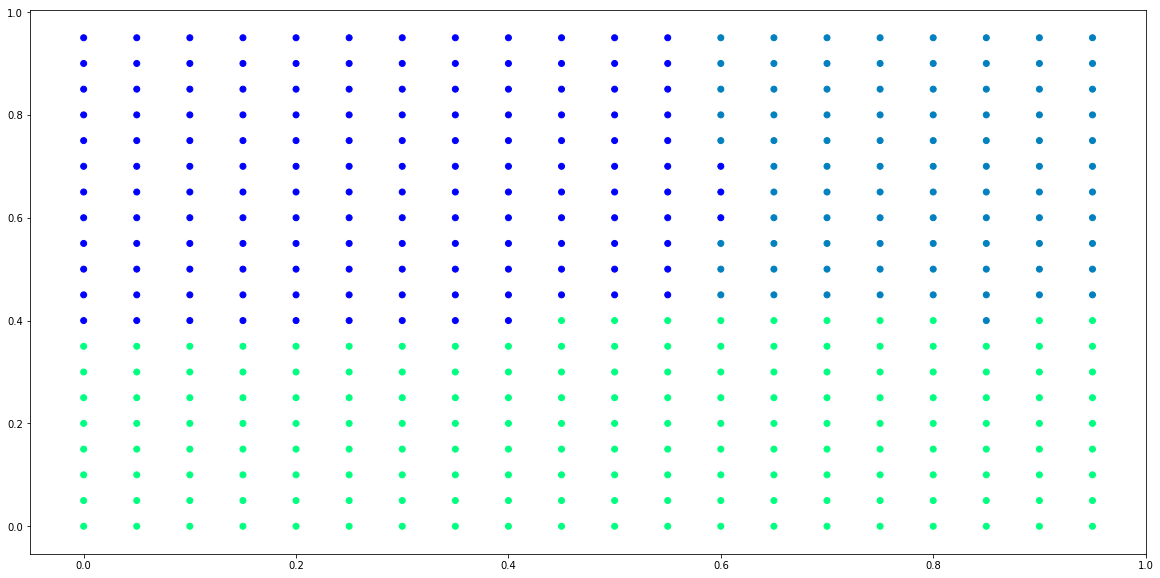

In [12]:
# plot predictions from posterior
plt.figure(figsize=(20,10))
plt.scatter(x_test[:,0], x_test[:,1], c=predictions)
plt.show()

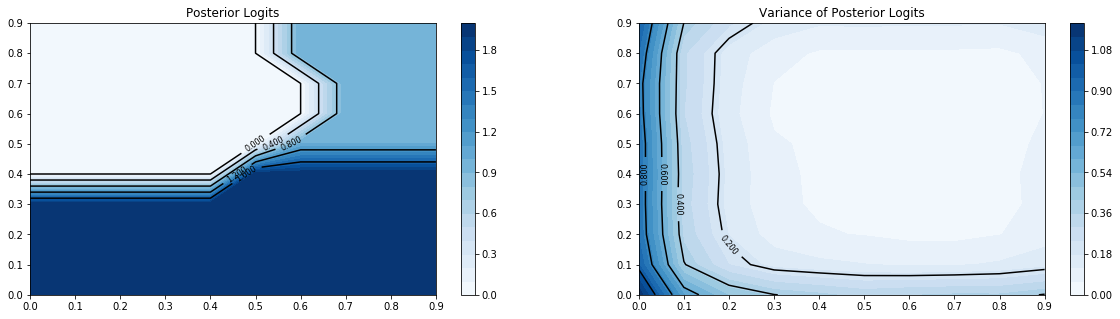

In [13]:
# plot the logit outputs and logit variances of model
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Posterior Logits')
gp_viz.classification.plot_contour(model,(0,1,.1))
plt.subplot(122)
plt.title('Variance of Posterior Logits')
gp_viz.classification.plot_contour(model,(0,1,.1),True)
plt.show()